In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.set_cmap('rainbow')
import pyemma
from tqdm import tqdm_notebook

<Figure size 432x288 with 0 Axes>

/home/psapir/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
states = np.arange(0, 2, 1).astype(int)
p11 = 0.99
p12 = 1-p11
p21 = 0.01
p22 = 1-p21
T_matrix = np.array([[p11, p12],
                     [p21, p22]])
for row in T_matrix:
    print(sum(row))

1.0
1.0


In [3]:
num_steps = 10000

In [4]:
trajectory = np.zeros(num_steps).astype(int)
trajectory[0] = 0
for i, s in tqdm_notebook(enumerate(trajectory[:-1])):
    trajectory[i+1] = np.random.choice(states, p=T_matrix[s])

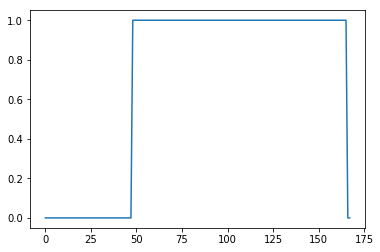

In [41]:
T_total = 168
data = trajectory[:T_total]
plt.plot(data)

In [72]:
def theory(k, t0):
    tau = np.log(k)
    return np.exp(-np.exp(tau)*t0+tau)

In [109]:
msm = pyemma.msm.bayesian_markov_model(data, 1, reversible=False,
                                       nsamples=100000, conf=0.95, count_mode='effective',
                                       mincount_connectivity=0, show_progress=False)

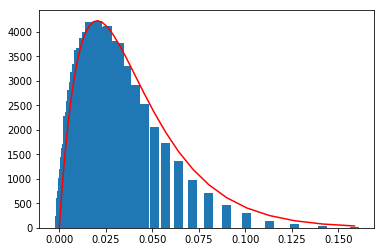

In [111]:
n_bars = 250
xmin, xmax = -13, -0.75
bar_width = np.abs(xmax - xmin)/n_bars * 0.1

bins = np.logspace(xmin, xmax, n_bars)
sample_rates = np.array(msm.sample_f('P'))[:,0,1]
sample_rates_hist, bin_edges = np.histogram(sample_rates, bins=bins, normed=False)
ks = np.array([theory(k, 49) for k in bins[:-1]])

coeff = np.max(sample_rates_hist) / np.max(ks)

plt.bar(bins[:-1], sample_rates_hist, width=bar_width)
plt.plot(bins[:-1], ks*coeff, 'red')

with open('single_transition_histogram.data', 'w') as f:
    for b, h in zip(bins[:-1], sample_rates_hist):
        f.write('{} {}\n'.format(b, h))

In [29]:
its_full = pyemma.msm.its(data, lags=np.linspace(1, 60, 20).astype(int), nits=1, errors='bayes')

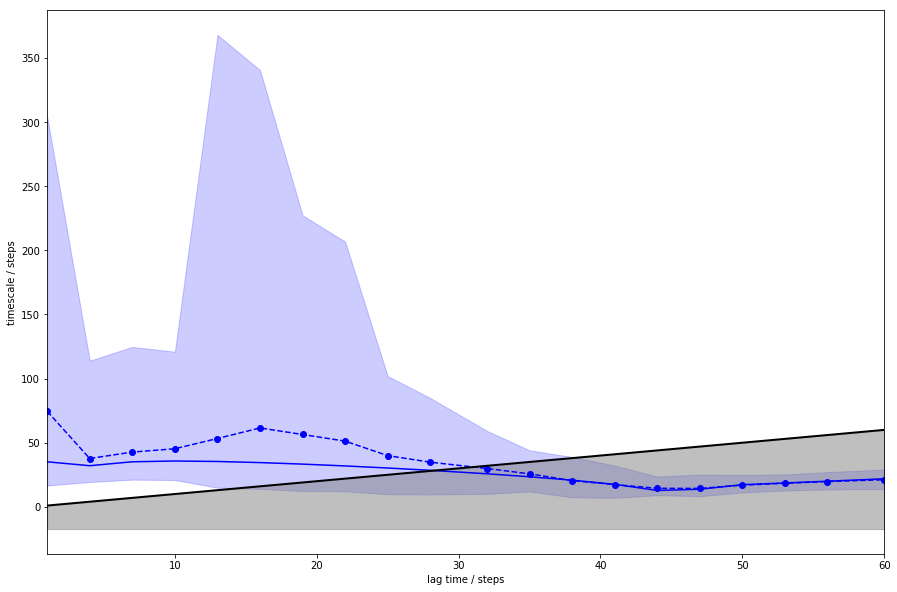

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
pyemma.plots.plot_implied_timescales(its_full, ylog=False, ax=axes)

In [88]:
LAG = 10
bayesian_msm = pyemma.msm.bayesian_markov_model(trajectory, lag=LAG, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=1)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=1)

print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0], sample_conf_r[0]))
msm = pyemma.msm.estimate_markov_model(trajectory, lag=LAG)

print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))
print('sum of weights = {:f}'.format(msm.pi.sum()))

Mean of first ITS: 53.331154
Confidence interval: [48.656652, 58.569945]
fraction of states used = 1.000000
fraction of counts used = 1.000000
sum of weights = 1.000000


# Analytical expectation

In [235]:
from sympy import *
from sympy.solvers import solve

In [236]:
tau, t0, T = symbols('tau t_{0} T')
a, b = symbols('a b')
delta = symbols('Delta')

p = exp(-t0/T*exp(tau) + tau)
diff_p = diff(p, tau)
tau_likely = solve(diff_p, tau)[1]
P = integrate(p, tau).as_expr_set_pairs()[1][0]
lower_integral = P.subs(tau, tau_likely) - P.subs(tau, a)
upper_integral = P.subs(tau, b) - P.subs(tau, tau_likely)
lower_bound = solve(lower_integral-delta/2, a)
upper_bound = solve(upper_integral-delta/2, b)

In [237]:
t0_num = np.where(data == 1)[0][0]
T_num = T_total
delta_num = 0.95
print(t0_num, T_num, delta_num)

2945 7000 0.95


In [238]:
tau_likely_num = tau_likely.subs(t0, t0_num).subs(T, T_num).evalf()
A = lower_bound[0].subs(t0, t0_num).subs(T, T_num).subs(delta, delta_num).evalf()
B = upper_bound[0].subs(t0, t0_num).subs(T, T_num).subs(delta, delta_num).evalf()

In [239]:
print('Mean of first ITS: {:f}'.format(tau_likely_num*T_num))
print('Confidence interval: [{:f}, {:f}]'.format(A, B))

Mean of first ITS: 6060.60932366234
Confidence interval: [0.296868341981307, 1.44440838594037]
